# Import Libraries

In [1]:
pwd

'/content'

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from model import *
from utils import *

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 104705196.62it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 75568118.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25648325.37it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15589630.74it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? False


# Data Statistics

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


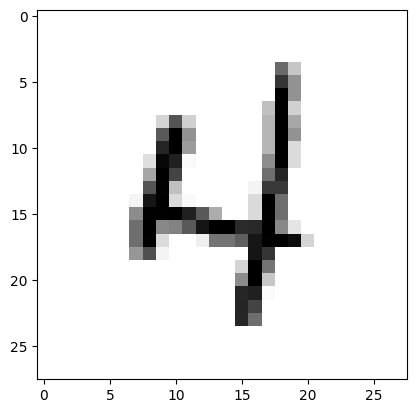

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_set = train_data.train_data
train_set = train_data.transform(train_set.numpy())

print('[Train]')
print(' - Numpy Shape:', train_data.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_data.train_data.size())
print(' - min:', torch.min(train_set))
print(' - max:', torch.max(train_set))
print(' - mean:', torch.mean(train_set))
print(' - std:', torch.std(train_set))
print(' - var:', torch.var(train_set))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


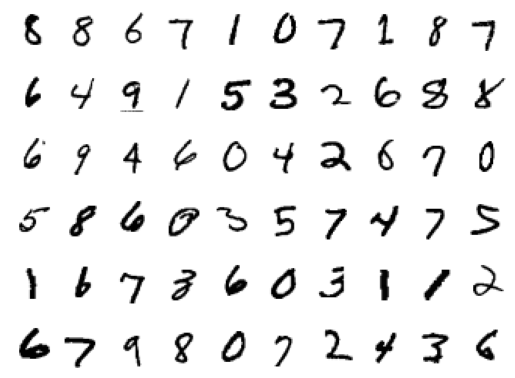

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

In [8]:
# from model import Net7

class Net7(nn.Module):
  def __init__(self):
    super(Net7, self).__init__()
    drop_out = 0.1
    # Input Block
    self.convblock1 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
      nn.BatchNorm2d(8),
      nn.Dropout(drop_out),
      nn.ReLU()
    ) # output_size = 26; RF = 3

    # CONVOLUTION BLOCK 1
    self.convblock2 = nn.Sequential(
      nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
      nn.BatchNorm2d(8),
      nn.Dropout(drop_out),
      nn.ReLU()
    ) # output_size = 24; RF = 5

    # TRANSITION BLOCK 1
    self.pool1 = nn.MaxPool2d(2, 2)
    # output_size = 12; RF = 6

    self.convblock3 = nn.Sequential(
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
      nn.BatchNorm2d(16),
      nn.Dropout(drop_out),
      nn.ReLU()
    ) # output_size = 12; RF = 10

    self.convblock4 = nn.Sequential(
      nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
      nn.BatchNorm2d(8),
      nn.Dropout(drop_out),
      nn.ReLU()
    ) # output_size = 10; RF = 14

    # TRANSITION BLOCK 2
    self.pool2 = nn.MaxPool2d(2, 2)
    # output_size = 5 ; RF = 16

    # CONVOLUTION BLOCK 2
    self.convblock5 = nn.Sequential(
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
      nn.BatchNorm2d(16),
      nn.Dropout(drop_out),
      nn.ReLU()
    ) # output_size = 5; RF = 24

    self.convblock6 = nn.Sequential(
      nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
      nn.BatchNorm2d(16),
      nn.Dropout(drop_out),
      nn.ReLU()
    ) # output_size = 5; RF = 32

    # OUTPUT BLOCK
    self.convblock7 = nn.Sequential(
      nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
    ) # output_size = 5
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=5)
    ) # output_size = 1

    self.convblock8 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
    )

  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.pool1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.pool2(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = self.gap(x)
    x = self.convblock8(x)
    x = x.view(-1, 10)
    return F.log_softmax(x, dim=-1)

# Model Params

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_summary(Net7, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 16, 12, 12]           1,152
      BatchNorm2d-11           [-1, 16, 12, 12]              32
          Dropout-12           [-1, 16, 12, 12]               0
             ReLU-13           [-1, 16, 12, 12]               0
           Conv2d-14            [-1, 8,

# Training and Testing


In [10]:
train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []

# Let's Train and test our model

In [ ]:
model =  Net7().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


Loss=0.23615267872810364 Batch_id=937 Accuracy=82.52: 100%|██████████| 938/938 [01:00<00:00, 15.44it/s]



Test set: Average loss: 0.3143, Accuracy: 8952/10000 (89.52%)

EPOCH: 1


Loss=0.11987605690956116 Batch_id=937 Accuracy=96.73: 100%|██████████| 938/938 [00:58<00:00, 15.94it/s]



Test set: Average loss: 0.1610, Accuracy: 9514/10000 (95.14%)

EPOCH: 2


Loss=0.27011075615882874 Batch_id=937 Accuracy=97.41: 100%|██████████| 938/938 [01:07<00:00, 13.95it/s]



Test set: Average loss: 0.1734, Accuracy: 9489/10000 (94.89%)

EPOCH: 3


Loss=0.15583573281764984 Batch_id=148 Accuracy=97.72:  16%|█▌        | 149/938 [04:24<9:04:09, 41.38s/it]

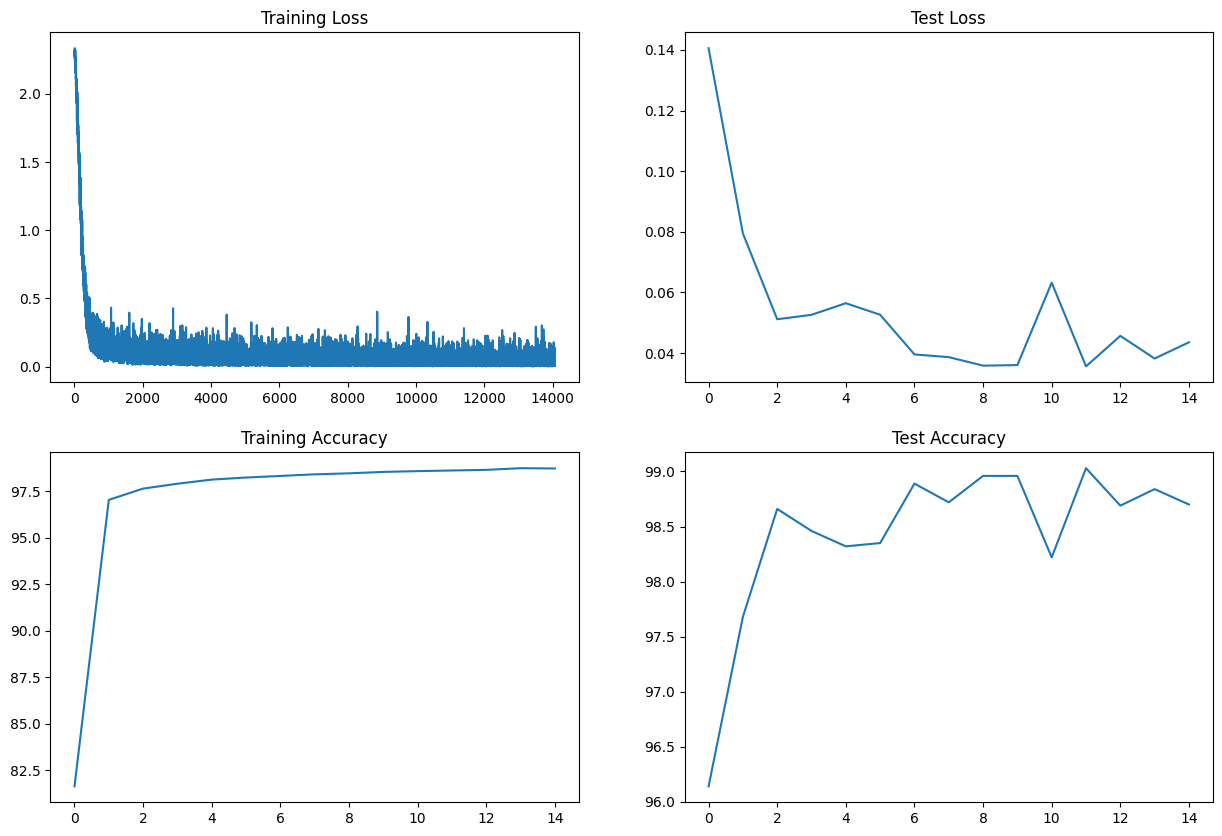

In [ ]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)